# Single & Multi-step Time Series Forecasting for _Multivariate_ data

Predict ```temp``` (temperature) feature for the city of _Vilnius_

- [weather data csv file](https://github.com/Eligijus112/Vilnius-weather-LSTM/tree/main/data)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout, Bidirectional
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import datetime
import numpy as np
import random

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Get number of available GPUs-
num_gpus = len(tf.config.list_physical_devices('GPU'))
# print(f"number of GPUs available = {num_gpus}")

if num_gpus > 0:
    # Check GPU availibility-
    gpu_devices = tf.config.list_physical_devices('GPU')
    # print(f"GPU: {gpu_devices}")

    if gpu_devices:
        print(f"GPU: {gpu_devices}")
        details = tf.config.experimental.get_device_details(gpu_devices[0])
        print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-04-27 14:51:37.556006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:51:37.576097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:51:37.576285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:51:37.576951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# Read in CSV file-
data = pd.read_csv("weather_data.csv")

In [6]:
data.shape

(294227, 25)

In [7]:
data.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_1h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [8]:
data.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,631152000,1990-01-01 00:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.52,-11.92,-7.74,-7.40,...,180,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
1,631155600,1990-01-01 01:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.56,-11.97,-7.82,-7.40,...,180,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
2,631159200,1990-01-01 02:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.67,-12.04,-7.77,-7.55,...,183,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
3,631162800,1990-01-01 03:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.74,-12.18,-7.86,-7.58,...,181,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,631166400,1990-01-01 04:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.66,-12.07,-7.78,-7.47,...,180,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [9]:
# Convert 'dt' feature to datetime object-
data['dt'] = [datetime.datetime.utcfromtimestamp(x) for x in data['dt']]

# Sort data by 'dt' in ascending manner-
data.sort_values('dt', inplace = True)

In [10]:
# Reset index-
data.reset_index(drop = True, inplace = True)

In [11]:
# Sanity check-
data.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1990-01-01 00:00:00,1990-01-01 00:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.52,-11.92,-7.74,-7.40,...,180,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
1,1990-01-01 01:00:00,1990-01-01 01:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.56,-11.97,-7.82,-7.40,...,180,NaN,NaN,NaN,NaN,90,701,Mist,mist,50n
2,1990-01-01 02:00:00,1990-01-01 02:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.67,-12.04,-7.77,-7.55,...,183,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
3,1990-01-01 03:00:00,1990-01-01 03:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.74,-12.18,-7.86,-7.58,...,181,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,1990-01-01 04:00:00,1990-01-01 04:00:00 +0000 UTC,7200,Vilnius TV Tower,54.687137,25.214648,-7.66,-12.07,-7.78,-7.47,...,180,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [12]:
print(f"Hourly weather data with min date: {data['dt'].min()} & max date: {data['dt'].max()}")

Hourly weather data with min date: 1990-01-01 00:00:00 & max date: 2020-11-30 23:00:00


In [13]:
data.dtypes

dt                     datetime64[ns]
dt_iso                         object
timezone                        int64
city_name                      object
lat                           float64
lon                           float64
temp                          float64
feels_like                    float64
temp_min                      float64
temp_max                      float64
pressure                        int64
sea_level                     float64
grnd_level                    float64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
rain_3h                       float64
snow_1h                       float64
snow_3h                       float64
clouds_all                      int64
weather_id                      int64
weather_main                   object
weather_description            object
weather_icon                   object
dtype: object

In [14]:
# Check for missing values-
if data.isna().values.any():
    print("Features having missing values with number of NAs are shown:\n")
    for col in data.columns.tolist():
        if data[col].isna().values.any():
            print(f"{col} has {data[col].isna().sum()} NAs")
else:
    print("There are no NAs in dataset")

Features having missing values with number of NAs are shown:

sea_level has 294227 NAs
grnd_level has 294227 NAs
rain_1h has 259196 NAs
rain_3h has 294227 NAs
snow_1h has 283144 NAs
snow_3h has 294224 NAs


### Visualizations

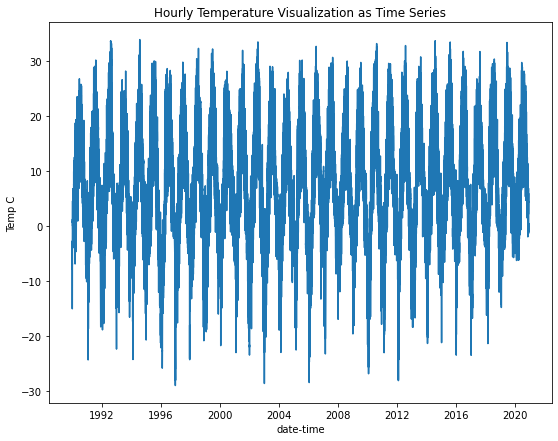

In [16]:
plt.figure(figsize = (9, 7))
plt.plot(data['dt'], data['temp'])
plt.title("Hourly Temperature Visualization as Time Series")
plt.xlabel("date-time")
plt.ylabel("Temp C")
plt.show()

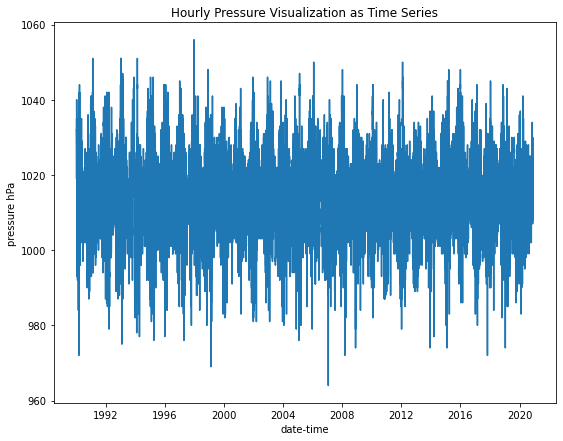

In [18]:
plt.figure(figsize = (9, 7))
plt.plot(data['dt'], data['pressure'])
plt.title("Hourly Pressure Visualization as Time Series")
plt.xlabel("date-time")
plt.ylabel("pressure hPa")
plt.show()

In [19]:
# Extract hour of day-
data['hour'] = [d.hour for d in data['dt']]

# Extract month of year-
data['month'] = [d.month for d in data['dt']]

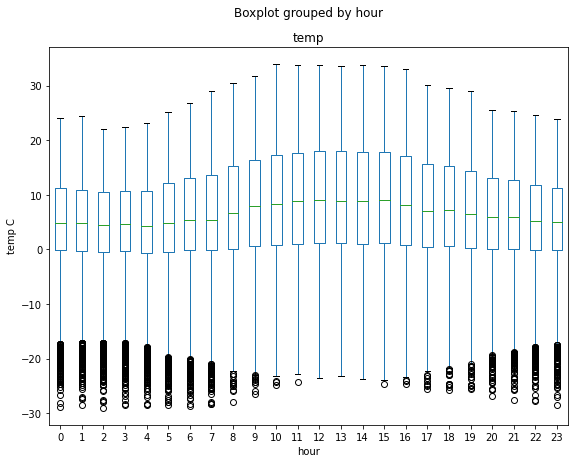

In [21]:
# Visualize box-plots grouped by hours-
data.boxplot('temp', by = 'hour', figsize = (9, 7), grid = False)
plt.ylabel("temp C")
plt.show()

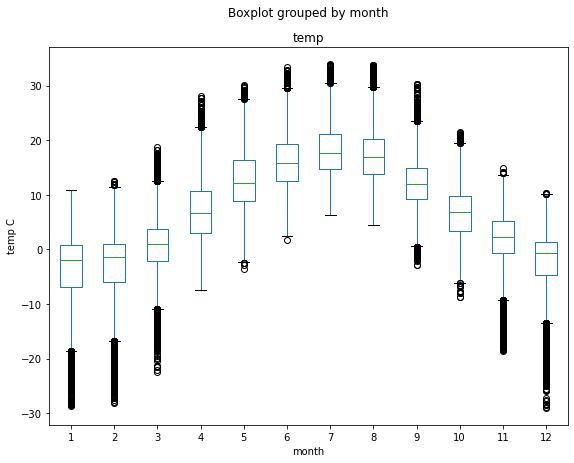

In [22]:
# Visualize box-plots grouped by months-
data.boxplot('temp', by = 'month', figsize = (9, 7), grid = False)
plt.ylabel("temp C")
plt.show()

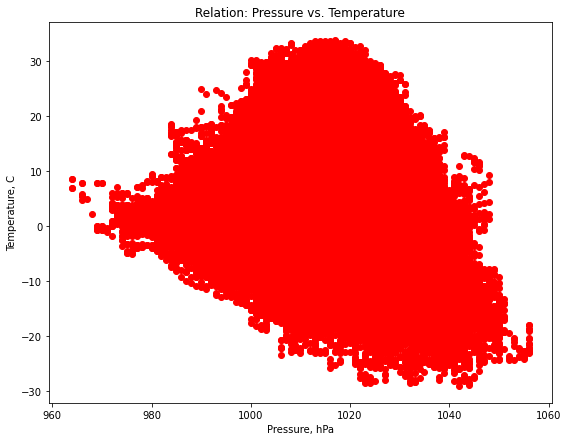

In [30]:
plt.figure(figsize = (9, 7))
plt.scatter(data['pressure'], data['temp'], c = 'r')
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.title("Relation: Pressure vs. Temperature")
plt.show()

In [23]:
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 543


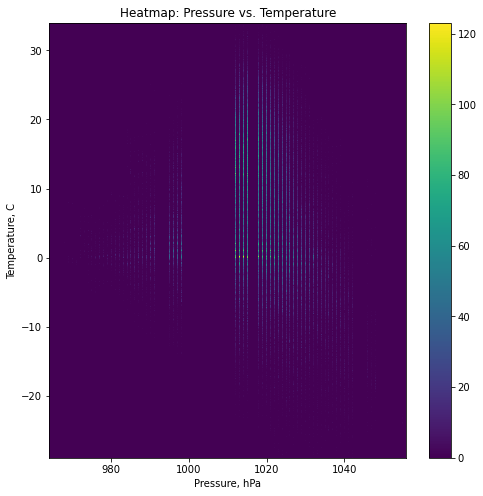

In [25]:
plt.figure(figsize = (8, 8))
plt.hist2d(data['pressure'], data['temp'], bins = (num_bins, num_bins))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.title("Heatmap: Pressure vs. Temperature")
plt.show()

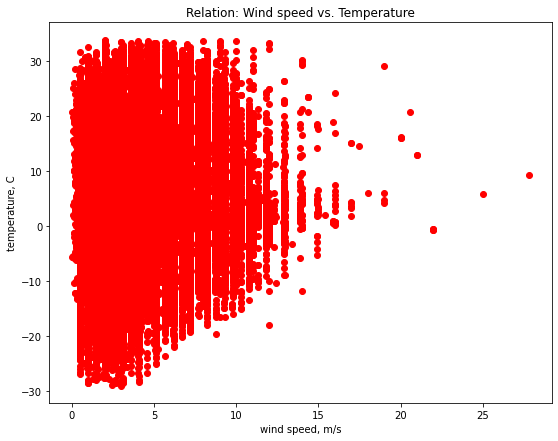

In [31]:
plt.figure(figsize = (9, 7))
plt.scatter(data['wind_speed'], data['temp'], c = 'r')
plt.xlabel('wind speed, m/s')
plt.ylabel('temperature, C')
ax.axis('tight')
plt.title("Relation: Wind speed vs. Temperature")
plt.show()

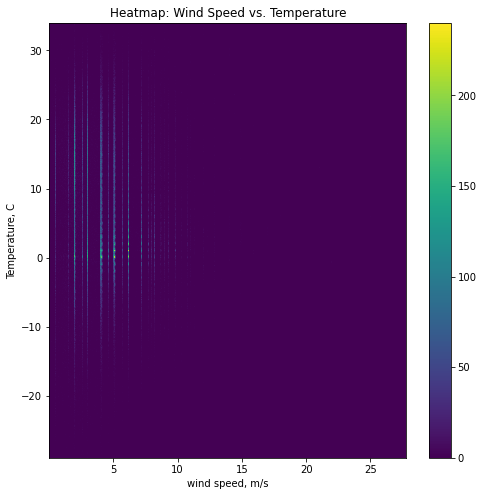

In [32]:
plt.figure(figsize = (8, 8))
plt.hist2d(data['wind_speed'], data['temp'], bins = (num_bins, num_bins))
plt.colorbar()
ax = plt.gca()
plt.xlabel('wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.title("Heatmap: Wind Speed vs. Temperature")
plt.show()

In [15]:
data.columns.tolist()

['dt',
 'dt_iso',
 'timezone',
 'city_name',
 'lat',
 'lon',
 'temp',
 'feels_like',
 'temp_min',
 'temp_max',
 'pressure',
 'sea_level',
 'grnd_level',
 'humidity',
 'wind_speed',
 'wind_deg',
 'rain_1h',
 'rain_3h',
 'snow_1h',
 'snow_3h',
 'clouds_all',
 'weather_id',
 'weather_main',
 'weather_description',
 'weather_icon']

In [15]:
# Select final features to be used in modeling-
features_final = ['temp', 'pressure', 'wind_speed']

In [16]:
# Select data to include selected features-
data = data.loc[:, features_final]

In [17]:
data.shape

(294227, 3)

In [18]:
# Sanity check- any missing values?
data.isna().values.any()

False

In [19]:
# Sanity check-
data.head()

,temp,pressure,wind_speed
0,-7.52,1032,2.00
1,-7.56,1032,2.00
2,-7.67,1028,2.08
3,-7.74,1028,2.18
4,-7.66,1028,2.12


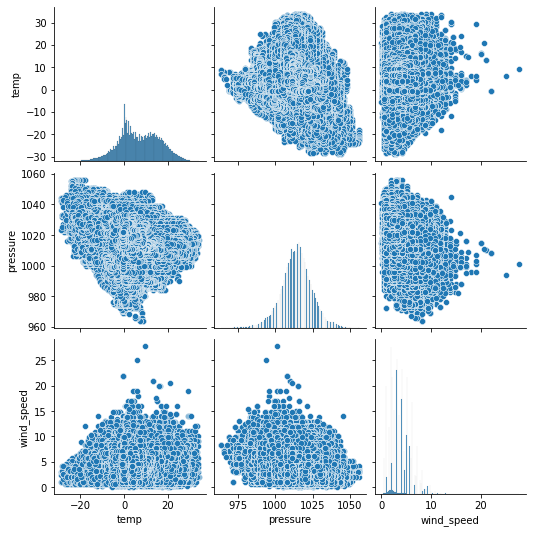

In [20]:
sns.pairplot(data = data)
plt.show()

In [25]:
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins (rule of thumb) = {num_bins}")

number of bins (rule of thumb) = 543


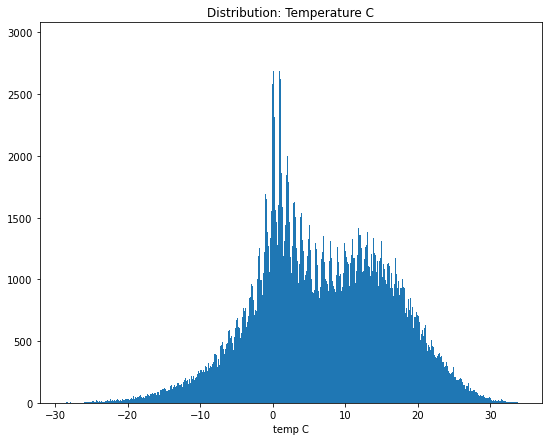

In [39]:
plt.figure(figsize = (9, 7))
plt.hist(data['temp'], bins = num_bins)
plt.xlabel("temp C")
plt.title("Distribution: Temperature C")
plt.show()

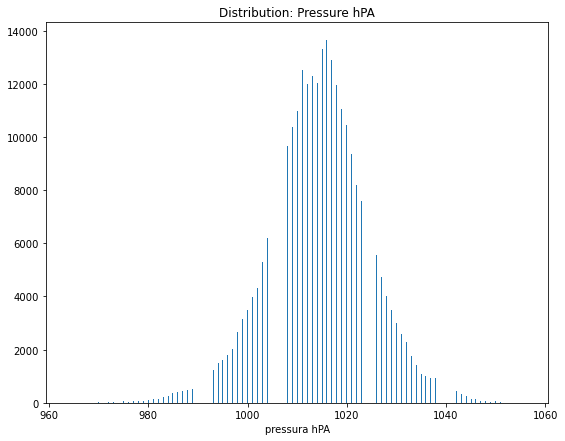

In [40]:
plt.figure(figsize = (9, 7))
plt.hist(data['pressure'], bins = num_bins)
plt.xlabel("pressura hPA")
plt.title("Distribution: Pressure hPA")
plt.show()

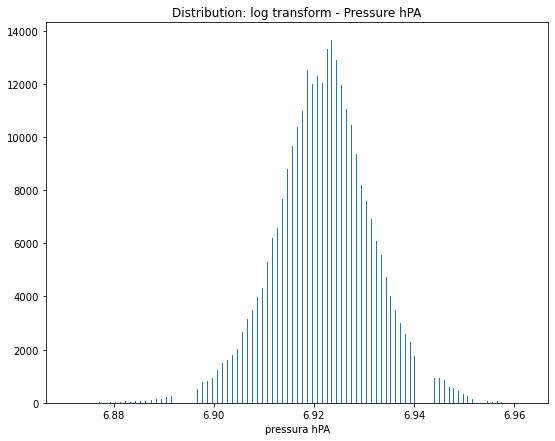

In [23]:
plt.figure(figsize = (9, 7))
plt.hist(np.log(data['pressure']), bins = num_bins)
plt.xlabel("pressura hPA")
plt.title("Distribution: log transform - Pressure hPA")
plt.show()

In [20]:
data['pressure'].value_counts()

1016    13636
1015    13325
1017    12896
1011    12537
1013    12299
        ...  
1052        4
1054        4
964         4
967         1
968         1
Name: pressure, Length: 92, dtype: int64

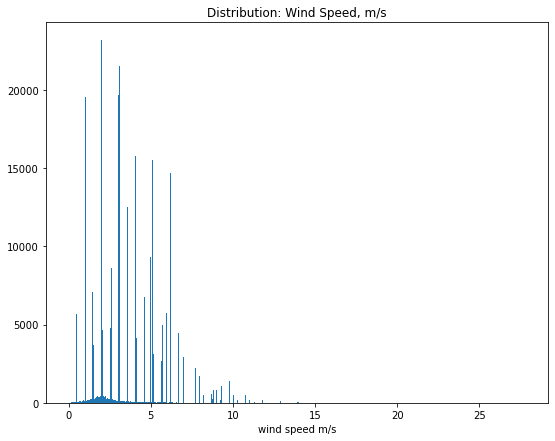

In [41]:
plt.figure(figsize = (9, 7))
plt.hist(data['wind_speed'], bins = num_bins)
plt.xlabel("wind speed m/s")
plt.title("Distribution: Wind Speed, m/s")
plt.show()

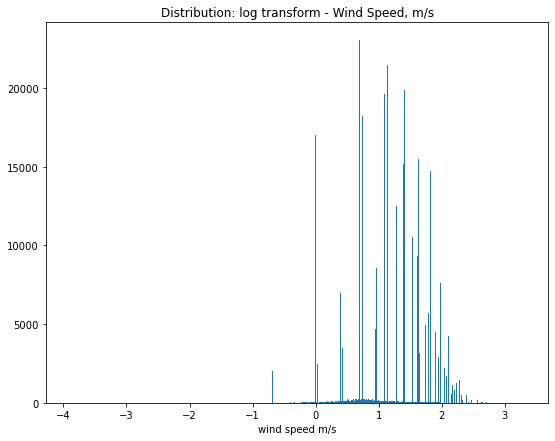

In [24]:
plt.figure(figsize = (9, 7))
plt.hist(np.log(data['wind_speed']), bins = num_bins)
plt.xlabel("wind speed m/s")
plt.title("Distribution: log transform - Wind Speed, m/s")
plt.show()

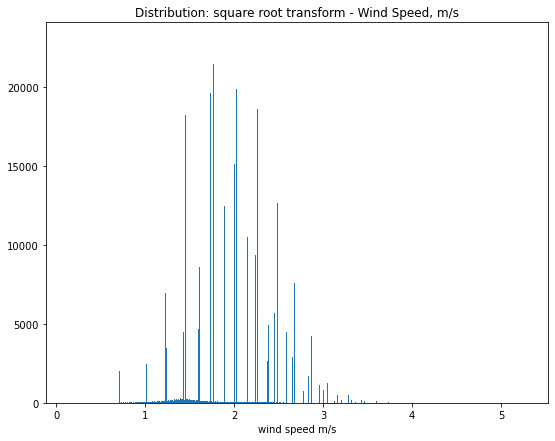

In [25]:
plt.figure(figsize = (9, 7))
plt.hist(np.sqrt(data['wind_speed']), bins = num_bins)
plt.xlabel("wind speed m/s")
plt.title("Distribution: square root transform - Wind Speed, m/s")
plt.show()

#### Observation

It seems that _wind_speed_ feature is tractable to transformations in order to convert it into a gaussian distribution.

In [20]:
# Use standard scaler-
std_scaler = StandardScaler()
data_scaled = std_scaler.fit_transform(data)

In [21]:
data_scaled.shape

(294227, 3)

In [22]:
# Sanity check-
data_scaled[:5, :]

array([[-1.53042436,  1.74595365, -0.85855379],
       [-1.53470911,  1.74595365, -0.85855379],
       [-1.54649218,  1.34930064, -0.82015948],
       [-1.55399049,  1.34930064, -0.7721666 ],
       [-1.54542099,  1.34930064, -0.80096233]])

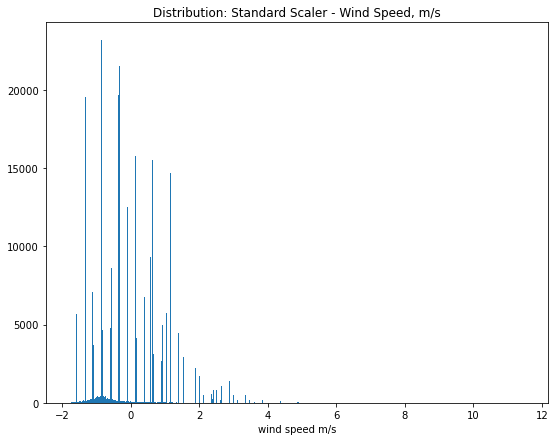

In [26]:
plt.figure(figsize = (9, 7))
plt.hist(data_scaled[:, 2], bins = num_bins)
plt.xlabel("wind speed m/s")
plt.title("Distribution: Standard Scaler - Wind Speed, m/s")
plt.show()

In [24]:
for i in range(data_scaled.shape[1]):
    print(f"feature: {i + 1}; min = {data_scaled[:, i].min():.4f},"
          f" & max = {data_scaled.max():.4f}")

feature: 1; min = -3.8281, & max = 11.5236
feature: 2; min = -4.9971, & max = 11.5236
feature: 3; min = -1.8088, & max = 11.5236


#### Reshape _input_ data for LSTM neural network

The input to an LSTM network is a 3D array- ```(samples, timesteps, features)```

- samples — total number of sequences constructed for training.

- timesteps — the length of the samples (aka _look-back_).

- features — number of features/attributes/channels used.

Therefore, first convert this data from 2D into 3D array.

__Predict ```temp``` (temperature) feature__.

In [23]:
def slicer(data, look_back = 10, future_window = 3):
    '''
    Create features and labels required for Multivariate Multi-step
    Forecasting by Seq2Seq deep learning models.
    
    NOTE: Target attribute is 'temp' which occurs in first position of 'data'.
    '''
    # Python3 lists to contain training data and target-
    X, y = list(), list()
    
    # Counter to loop through the 2-D matrix dataset to create 'X' and 'y'-
    i = look_back
    
    while i <= (len(data) - future_window):
        X.append(data[i - look_back: i, :])
    
        # This does NOT include the current target value for 'i' but rather
        # i + 1 and i + 2-
        y.append(data[i: i + future_window, 0])
    
        # This INCLUDES the current target value for 'i', as in-
        # i and i + 1-
        # X[i - 1: i + future_window - 1, 2]
    
        i += 1

    # Convert from list to np arrays-
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y


### Define hyper-parameters for _Single step_ Sequence Modeling

In [24]:
# Number of lags (hours back) or look back-
look_back = 48

# Steps ahead to forecast-
future_window = 1

In [25]:
# Get features 'X' and labels 'y' using processed data-
X, y = slicer(
    data = data_scaled,
    look_back = look_back, future_window = future_window
)

In [26]:
# Sanity check-
X.shape, y.shape

((294179, 48, 3), (294179, 1))

In [27]:
data_scaled[:49, :]

array([[-1.53042436,  1.74595365, -0.85855379],
       [-1.53470911,  1.74595365, -0.85855379],
       [-1.54649218,  1.34930064, -0.82015948],
       [-1.55399049,  1.34930064, -0.7721666 ],
       [-1.54542099,  1.34930064, -0.80096233],
       [-1.4832921 ,  1.54762714, -0.85855379],
       [-1.47579379,  1.54762714, -0.85855379],
       [-1.46722429,  1.54762714, -0.85855379],
       [-1.40188184,  1.15097413, -0.75296945],
       [-1.37510215,  1.15097413, -0.74817016],
       [-1.30761732,  1.15097413, -0.72897301],
       [-1.29369188,  1.25013738, -0.85855379],
       [-1.28940713,  1.25013738, -0.85855379],
       [-1.28512238,  1.25013738, -0.85855379],
       [-1.25620031,  1.15097413, -1.3384826 ],
       [-1.2572715 ,  1.15097413, -1.3384826 ],
       [-1.248702  ,  1.15097413, -1.3384826 ],
       [-1.21013924,  1.05181088, -0.37862497],
       [-1.21121043,  1.05181088, -0.37862497],
       [-1.20264092,  1.05181088, -0.37862497],
       [-1.15443748,  1.05181088, -0.378

In [28]:
# Sanity check-
X[0], y[0]

(array([[-1.53042436,  1.74595365, -0.85855379],
        [-1.53470911,  1.74595365, -0.85855379],
        [-1.54649218,  1.34930064, -0.82015948],
        [-1.55399049,  1.34930064, -0.7721666 ],
        [-1.54542099,  1.34930064, -0.80096233],
        [-1.4832921 ,  1.54762714, -0.85855379],
        [-1.47579379,  1.54762714, -0.85855379],
        [-1.46722429,  1.54762714, -0.85855379],
        [-1.40188184,  1.15097413, -0.75296945],
        [-1.37510215,  1.15097413, -0.74817016],
        [-1.30761732,  1.15097413, -0.72897301],
        [-1.29369188,  1.25013738, -0.85855379],
        [-1.28940713,  1.25013738, -0.85855379],
        [-1.28512238,  1.25013738, -0.85855379],
        [-1.25620031,  1.15097413, -1.3384826 ],
        [-1.2572715 ,  1.15097413, -1.3384826 ],
        [-1.248702  ,  1.15097413, -1.3384826 ],
        [-1.21013924,  1.05181088, -0.37862497],
        [-1.21121043,  1.05181088, -0.37862497],
        [-1.20264092,  1.05181088, -0.37862497],
        [-1.15443748

In [29]:
# Validation data size-
val_size = 0.2
# Use 20% of data as validation data.

In [30]:
# Split data into train and testing sets-
X_train = X[0:int(len(X) * (1 - val_size))]
X_test = X[int(len(X) * (1 - val_size)):]

In [31]:
# Create training and testing labels-
y_train = y[0:int(len(y) * (1 - val_size))]
y_test = y[int(len(y) * (1 - val_size)):]

In [32]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (235343, 48, 3), y_train.shape: (235343, 1)
X_test.shape: (58836, 48, 3), y_test.shape: (58836, 1)


In [33]:
print(f"number of lag/look-back = {X_train.shape[1]} & number of features = {X_train.shape[2]}")

number of lag/look-back = 48 & number of features = 3


In [34]:
print(f"number of feature output = {y_train.shape[1]}")

number of feature output = 1


### Define _LSTM_ architecture

In [42]:
def Single_LSTM(X, y):
    # Function to define stacked LSTM architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = False
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [43]:
def Stacked_LSTM(X, y):
    # Function to define stacked LSTM architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = True
        )
    )
    # return sequence for the next LSTM to process.
    
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            return_sequences = True
        )
    )

    model.add(
        LSTM(
            units = 32, activation = tf.keras.activations.tanh,
            return_sequences = False
        )
    )

    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model

In [44]:
def Stacked_Bi_LSTM(X, y):
    # Function to define stacked Bidirectional LSTM architecture.
    model = Sequential()
    
    model.add(
        Bidirectional(
            LSTM(
                units = 64, return_sequences = True,
            ),
            input_shape = (X.shape[1], X.shape[2])
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(
                units = 64, return_sequences = True,
            )
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(
                units = 32, return_sequences = False,
            )
        )
    )
    
    model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [53]:
# Instantiate single layer LSTM model-
single_model = Single_LSTM(X = X_train, y = y_train)

In [39]:
# Instantiate stacked LSTM model-
stacked_model = Stacked_LSTM(X = X_train, y = y_train)

In [40]:
# Instantiate stacked bi-directional LSTM-
stacked_bi_model = Stacked_Bi_LSTM(X = X_train, y = y_train)

In [54]:
# Sanity check-
pred_single = single_model(X_train[:2])
pred_stacked = stacked_model(X_train[:2])
pred_bi_stacked = stacked_bi_model(X_train[:2])

In [55]:
print(f"Single layer LSTM output shape: {pred_single.shape},"
      f" Stacked LSTM output shape: {pred_stacked.shape}, "
      f"Bi-directional Stacked LSTM output shape: {pred_bi_stacked.shape}"
      f" & ground truth output shape: {y_train[:2].shape}")

Single layer LSTM output shape: (2, 1), Stacked LSTM output shape: (2, 1), Bi-directional Stacked LSTM output shape: (2, 1) & ground truth output shape: (2, 1)


In [43]:
# Compile defined model-
single_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [44]:
stacked_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [45]:
stacked_bi_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [46]:
# Get model summary-
single_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            17408     
                                                                 
 dropout (Dropout)           (None, 48, 64)            0         
                                                                 
 dense (Dense)               (None, 48, 1)             65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [47]:
stacked_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 48, 64)            17408     
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 62,881
Trainable params: 62,881
Non-trainable params: 0
_________________________________________________________________


In [48]:
stacked_bi_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 128)          34816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 48, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [49]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", min_delta = 0,
    patience = 5, verbose = 0,
    mode = "auto", baseline = None,
    restore_best_weights = True,
)


In [50]:
# Train single-layer LSTM model-
train_history_lstm = single_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50


2022-04-27 13:18:30.573379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-27 13:18:30.672448: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


460/460 [==============================] - 4s 5ms/step - loss: 0.1516 - val_loss: 0.1121
Epoch 2/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1182 - val_loss: 0.1095
Epoch 3/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1148 - val_loss: 0.1130
Epoch 4/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1131 - val_loss: 0.1065
Epoch 5/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1120 - val_loss: 0.1111
Epoch 6/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1107 - val_loss: 0.1051
Epoch 7/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1100 - val_loss: 0.1054
Epoch 8/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1091 - val_loss: 0.1050
Epoch 9/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1087 - val_loss: 0.1042
Epoch 10/50
460/460 [==============================] - 2s 5ms/step - loss: 0.1082 - val_loss: 0.1045
Epoch 11/5

In [51]:
# Train stacked LSTM model-
train_history_stacked_lstm = stacked_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
460/460 [==============================] - 7s 10ms/step - loss: 0.0344 - val_loss: 0.0059
Epoch 2/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0149 - val_loss: 0.0052
Epoch 3/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 4/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0146 - val_loss: 0.0057
Epoch 5/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0147 - val_loss: 0.0053
Epoch 6/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0147 - val_loss: 0.0054
Epoch 7/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0145 - val_loss: 0.0072


In [52]:
# Train bi-directional stacked LSTM model-
train_history_bi_stacked_lstm = stacked_bi_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
460/460 [==============================] - 12s 19ms/step - loss: 0.0280 - val_loss: 0.0081
Epoch 2/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0137 - val_loss: 0.0058
Epoch 3/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0115 - val_loss: 0.0057
Epoch 4/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0118 - val_loss: 0.0077
Epoch 5/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0115 - val_loss: 0.0057
Epoch 6/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0107 - val_loss: 0.0057
Epoch 7/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0106 - val_loss: 0.0055
Epoch 8/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0103 - val_loss: 0.0064
Epoch 9/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0101 - val_loss: 0.0061
Epoch 10/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0100 - val_l

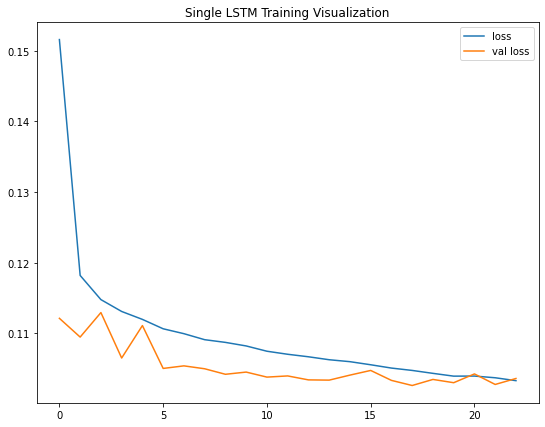

In [53]:
# Visualize training - LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_lstm.history['loss'], label = 'loss')
plt.plot(train_history_lstm.history['val_loss'], label = 'val loss')
plt.title("Single LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

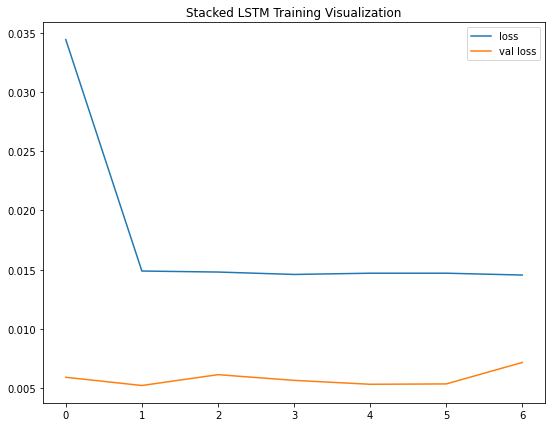

In [54]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

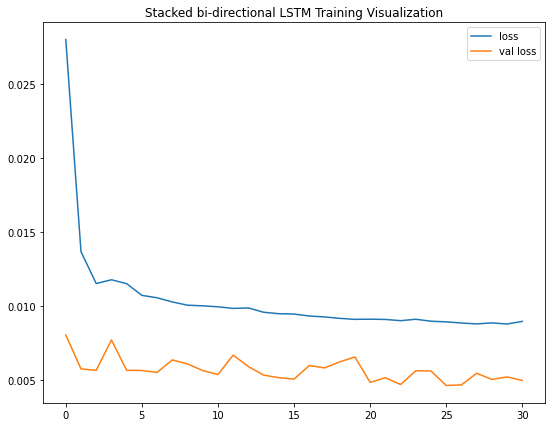

In [55]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_bi_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked bi-directional LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [56]:
# Get predictions and ground truth for model's performance comparisons-
ground_truth_single = [y[0] for y in y_test]
predictions_single = [y_pred[0] for y_pred in single_model.predict(X_test)]

In [57]:
predictions_stacked = [y_pred[0] for y_pred in stacked_model.predict(X_test)]
predictions_bi_stacked = [y_pred[0] for y_pred in stacked_bi_model.predict(X_test)]

In [58]:
# Sanity check-
len(ground_truth_single), len(predictions_single), len(predictions_stacked), len(predictions_bi_stacked)

(58836, 58836, 58836, 58836)

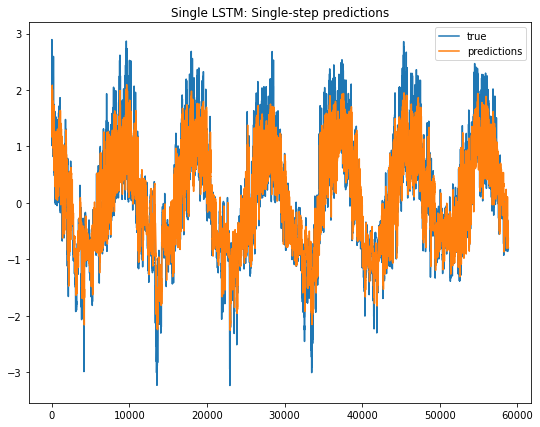

In [59]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single, label = 'predictions')
plt.title("Single LSTM: Single-step predictions")
plt.legend(loc =  'best')
plt.show()

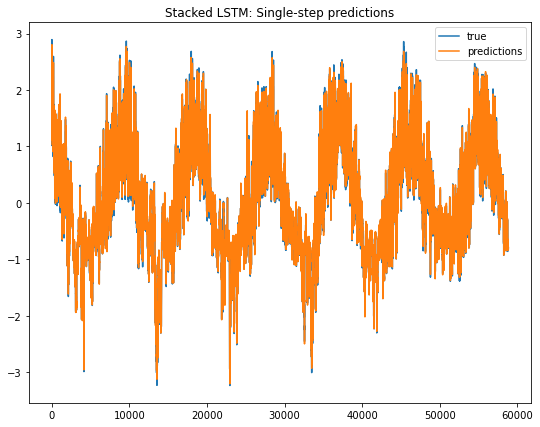

In [60]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_stacked, label = 'predictions')
plt.title("Stacked LSTM: Single-step predictions")
plt.legend(loc =  'best')
plt.show()

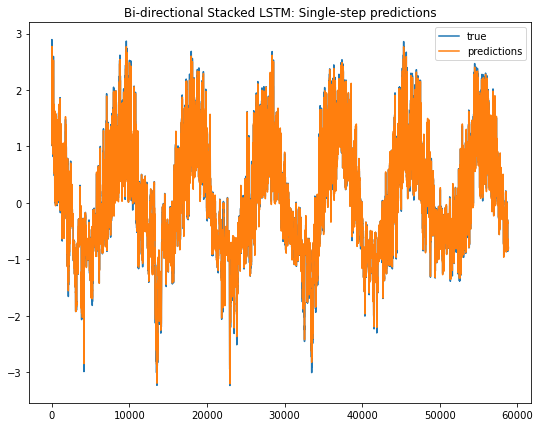

In [61]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_bi_stacked, label = 'predictions')
plt.title("Bi-directional Stacked LSTM: Single-step predictions")
plt.legend(loc =  'best')
plt.show()

In [71]:
# Compute MAE-
mae_single = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_single)
mae_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mae_bi_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)

In [72]:
# Compute MSE-
mse_single = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_single)
mse_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mse_bi_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)

In [73]:
# Compute RMSE-
rmse_single = np.sqrt(mse_single)
rmse_stacked = np.sqrt(mse_stacked)
rmse_bi_stacked = np.sqrt(mse_bi_stacked)

In [74]:
print("Validation metrics for different LSTM models are:")
print(f"MAE single = {mae_single:.4f}, MAE stacked = {mae_stacked:.4f} & MAE bi-directional stacked = {mae_bi_stacked:.4f}")
print(f"MSE single = {mse_single:.4f}, MSE stacked = {mse_stacked:.4f} & MSE bi-directional stacked = {mse_bi_stacked:.4f}")
print(f"RMSE single = {rmse_single:.4f}, RMSE stacked = {rmse_stacked:.4f} & RMSE bi-directional stacked = {rmse_bi_stacked:.4f}")

Validation metrics for different LSTM models are:
MAE single = 0.3295, MAE stacked = 0.0511 & MAE bi-directional stacked = 0.0483
MSE single = 0.1787, MSE stacked = 0.0052 & MSE bi-directional stacked = 0.0047
RMSE single = 0.4227, RMSE stacked = 0.0723 & RMSE bi-directional stacked = 0.0683


In [76]:
# Save trained models-
single_model.save("Single_LSTM_weather_model.h5", overwrite = True)
stacked_model.save("Stacked_LSTM_weather_model.h5", overwrite = True)
stacked_bi_model.save("Stacked_bi_Directional_LSTM_weather_model.h5", overwrite = True)

In [77]:
del single_model, stacked_model, stacked_bi_model

### Define hyper-parameters for _Multi step_ Sequence Modeling

In [27]:
# Number of lags (hours back) or look back-
look_back = 48

# Steps ahead to forecast-
future_window = 10

In [28]:
# Get features 'X' and labels 'y' using processed data-
X, y = slicer(
    data = data_scaled,
    look_back = look_back, future_window = future_window
)

In [29]:
# Sanity check-
X.shape, y.shape

((294170, 48, 3), (294170, 10))

In [30]:
data_scaled[:49, :]

array([[-1.53042436,  1.74595365, -0.85855379],
       [-1.53470911,  1.74595365, -0.85855379],
       [-1.54649218,  1.34930064, -0.82015948],
       [-1.55399049,  1.34930064, -0.7721666 ],
       [-1.54542099,  1.34930064, -0.80096233],
       [-1.4832921 ,  1.54762714, -0.85855379],
       [-1.47579379,  1.54762714, -0.85855379],
       [-1.46722429,  1.54762714, -0.85855379],
       [-1.40188184,  1.15097413, -0.75296945],
       [-1.37510215,  1.15097413, -0.74817016],
       [-1.30761732,  1.15097413, -0.72897301],
       [-1.29369188,  1.25013738, -0.85855379],
       [-1.28940713,  1.25013738, -0.85855379],
       [-1.28512238,  1.25013738, -0.85855379],
       [-1.25620031,  1.15097413, -1.3384826 ],
       [-1.2572715 ,  1.15097413, -1.3384826 ],
       [-1.248702  ,  1.15097413, -1.3384826 ],
       [-1.21013924,  1.05181088, -0.37862497],
       [-1.21121043,  1.05181088, -0.37862497],
       [-1.20264092,  1.05181088, -0.37862497],
       [-1.15443748,  1.05181088, -0.378

In [31]:
# Sanity check-
X[0]

array([[-1.53042436,  1.74595365, -0.85855379],
       [-1.53470911,  1.74595365, -0.85855379],
       [-1.54649218,  1.34930064, -0.82015948],
       [-1.55399049,  1.34930064, -0.7721666 ],
       [-1.54542099,  1.34930064, -0.80096233],
       [-1.4832921 ,  1.54762714, -0.85855379],
       [-1.47579379,  1.54762714, -0.85855379],
       [-1.46722429,  1.54762714, -0.85855379],
       [-1.40188184,  1.15097413, -0.75296945],
       [-1.37510215,  1.15097413, -0.74817016],
       [-1.30761732,  1.15097413, -0.72897301],
       [-1.29369188,  1.25013738, -0.85855379],
       [-1.28940713,  1.25013738, -0.85855379],
       [-1.28512238,  1.25013738, -0.85855379],
       [-1.25620031,  1.15097413, -1.3384826 ],
       [-1.2572715 ,  1.15097413, -1.3384826 ],
       [-1.248702  ,  1.15097413, -1.3384826 ],
       [-1.21013924,  1.05181088, -0.37862497],
       [-1.21121043,  1.05181088, -0.37862497],
       [-1.20264092,  1.05181088, -0.37862497],
       [-1.15443748,  1.05181088, -0.378

In [32]:
y[0]

array([-1.42866153, -1.42544797, -1.41687847, -1.41152253, -1.40295303,
       -1.37403096, -1.36546146, -1.35582077, -1.29262069, -1.2915495 ])

In [33]:
data_scaled[48:58, 0]

array([-1.42866153, -1.42544797, -1.41687847, -1.41152253, -1.40295303,
       -1.37403096, -1.36546146, -1.35582077, -1.29262069, -1.2915495 ])

In [34]:
np.all(y[0] == data_scaled[48:58, 0])

True

In [ ]:
'''
start = 48

for i in range(5):
    stop = start + 10
    print(f"start = {start}, stop = {stop}, i  = {i}. Equals? {np.all(y[i] == data_scaled[start: stop, 0])}")
    start = stop + 10
'''

In [35]:
# Validation data size-
val_size = 0.2
# Use 20% of data as validation data.

In [36]:
# Split data into train and testing sets-
X_train = X[0:int(len(X) * (1 - val_size))]
X_test = X[int(len(X) * (1 - val_size)):]

In [37]:
# Create training and testing labels-
y_train = y[0:int(len(y) * (1 - val_size))]
y_test = y[int(len(y) * (1 - val_size)):]

In [38]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (235336, 48, 3), y_train.shape: (235336, 10)
X_test.shape: (58834, 48, 3), y_test.shape: (58834, 10)


In [39]:
print(f"number of lag/look-back = {X_train.shape[1]} & number of features = {X_train.shape[2]}")

number of lag/look-back = 48 & number of features = 3


In [40]:
print(f"number of feature output = {y_train.shape[1]}")

number of feature output = 10


In [60]:
X[0]

array([[-1.53042436,  1.74595365, -0.85855379],
       [-1.53470911,  1.74595365, -0.85855379],
       [-1.54649218,  1.34930064, -0.82015948],
       [-1.55399049,  1.34930064, -0.7721666 ],
       [-1.54542099,  1.34930064, -0.80096233],
       [-1.4832921 ,  1.54762714, -0.85855379],
       [-1.47579379,  1.54762714, -0.85855379],
       [-1.46722429,  1.54762714, -0.85855379],
       [-1.40188184,  1.15097413, -0.75296945],
       [-1.37510215,  1.15097413, -0.74817016],
       [-1.30761732,  1.15097413, -0.72897301],
       [-1.29369188,  1.25013738, -0.85855379],
       [-1.28940713,  1.25013738, -0.85855379],
       [-1.28512238,  1.25013738, -0.85855379],
       [-1.25620031,  1.15097413, -1.3384826 ],
       [-1.2572715 ,  1.15097413, -1.3384826 ],
       [-1.248702  ,  1.15097413, -1.3384826 ],
       [-1.21013924,  1.05181088, -0.37862497],
       [-1.21121043,  1.05181088, -0.37862497],
       [-1.20264092,  1.05181088, -0.37862497],
       [-1.15443748,  1.05181088, -0.378

In [61]:
y[0]

array([-1.42866153, -1.42544797, -1.41687847, -1.41152253, -1.40295303,
       -1.37403096, -1.36546146, -1.35582077, -1.29262069, -1.2915495 ])

In [45]:
# Instantiate single layer LSTM model-
single_model = Single_LSTM(X = X_train, y = y_train)

2022-04-27 14:53:15.335411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 14:53:15.336799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:53:15.337120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:53:15.337372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [46]:
# Instantiate stacked LSTM model-
stacked_model = Stacked_LSTM(X = X_train, y = y_train)

In [47]:
# Instantiate stacked bi-directional LSTM-
stacked_bi_model = Stacked_Bi_LSTM(X = X_train, y = y_train)

In [51]:
# Sanity check-
pred_single = single_model(X[:2])
pred_stacked = stacked_model(X[:2])
pred_bi_stacked = stacked_bi_model(X[:2])

In [52]:
pred_single.shape, pred_stacked.shape, pred_bi_stacked.shape, y[:2].shape

(TensorShape([2, 10]), TensorShape([2, 10]), TensorShape([2, 10]), (2, 10))

In [53]:
# Compile defined model-
single_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [54]:
stacked_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [55]:
stacked_bi_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [56]:
# Get model summary-
single_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
Total params: 18,058
Trainable params: 18,058
Non-trainable params: 0
_________________________________________________________________


In [57]:
stacked_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 48, 64)            17408     
                                                                 
 lstm_2 (LSTM)               (None, 48, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 63,178
Trainable params: 63,178
Non-trainable params: 0
_________________________________________________________________


In [58]:
stacked_bi_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 128)          34816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 48, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                      

In [59]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", min_delta = 0,
    patience = 5, verbose = 0,
    mode = "auto", baseline = None,
    restore_best_weights = True,
)


In [60]:
# Train single-layer LSTM model-
train_history_lstm = single_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
460/460 [==============================] - 3s 5ms/step - loss: 0.0682 - val_loss: 0.0404
Epoch 2/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0450 - val_loss: 0.0381
Epoch 3/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0428 - val_loss: 0.0378
Epoch 4/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0416 - val_loss: 0.0359
Epoch 5/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0406 - val_loss: 0.0358
Epoch 6/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0399 - val_loss: 0.0358
Epoch 7/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0394 - val_loss: 0.0340
Epoch 8/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0389 - val_loss: 0.0338
Epoch 9/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0386 - val_loss: 0.0354
Epoch 10/50
460/460 [==============================] - 2s 5ms/step - loss: 0.0382 - val_loss: 0.0337

In [61]:
# Train stacked LSTM model-
train_history_stacked_lstm = stacked_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
460/460 [==============================] - 7s 11ms/step - loss: 0.0737 - val_loss: 0.0384
Epoch 2/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0479 - val_loss: 0.0379
Epoch 3/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0453 - val_loss: 0.0362
Epoch 4/50
460/460 [==============================] - 4s 10ms/step - loss: 0.0442 - val_loss: 0.0346
Epoch 5/50
460/460 [==============================] - 4s 10ms/step - loss: 0.0430 - val_loss: 0.0344
Epoch 6/50
460/460 [==============================] - 4s 10ms/step - loss: 0.0423 - val_loss: 0.0346
Epoch 7/50
460/460 [==============================] - 4s 10ms/step - loss: 0.0412 - val_loss: 0.0337
Epoch 8/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0405 - val_loss: 0.0342
Epoch 9/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0398 - val_loss: 0.0356
Epoch 10/50
460/460 [==============================] - 4s 9ms/step - loss: 0.0390 - val_loss: 0

In [62]:
# Train bi-directional stacked LSTM model-
train_history_bi_stacked_lstm = stacked_bi_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
460/460 [==============================] - 12s 20ms/step - loss: 0.0637 - val_loss: 0.0401
Epoch 2/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0438 - val_loss: 0.0378
Epoch 3/50
460/460 [==============================] - 8s 17ms/step - loss: 0.0412 - val_loss: 0.0346
Epoch 4/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0388 - val_loss: 0.0339
Epoch 5/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0372 - val_loss: 0.0345
Epoch 6/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0361 - val_loss: 0.0339
Epoch 7/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0348 - val_loss: 0.0357
Epoch 8/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0337 - val_loss: 0.0354
Epoch 9/50
460/460 [==============================] - 8s 18ms/step - loss: 0.0324 - val_loss: 0.0341


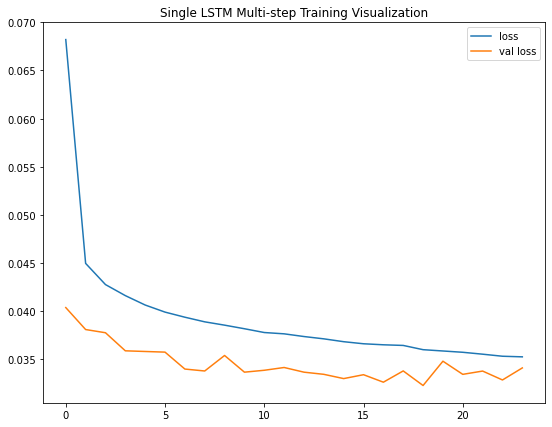

In [63]:
# Visualize training - LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_lstm.history['loss'], label = 'loss')
plt.plot(train_history_lstm.history['val_loss'], label = 'val loss')
plt.title("Single LSTM Multi-step Training Visualization")
plt.legend(loc = 'best')
plt.show()

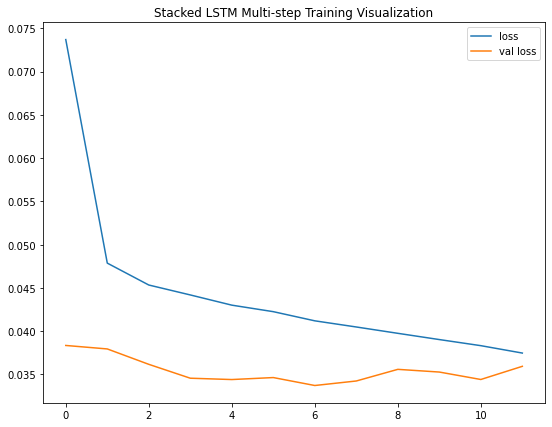

In [64]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked LSTM Multi-step Training Visualization")
plt.legend(loc = 'best')
plt.show()

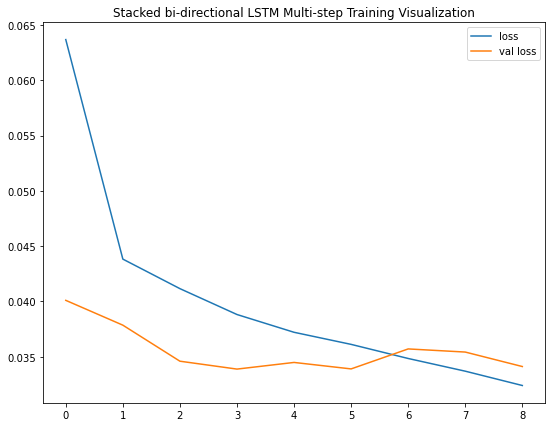

In [65]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_bi_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked bi-directional LSTM Multi-step Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [66]:
# Get predictions and ground truth for model's performance comparisons-
ground_truth_single = [y[0] for y in y_test]
predictions_single = [y_pred[0] for y_pred in single_model.predict(X_test)]

In [67]:
predictions_stacked = [y_pred[0] for y_pred in stacked_model.predict(X_test)]
predictions_bi_stacked = [y_pred[0] for y_pred in stacked_bi_model.predict(X_test)]

In [68]:
# Sanity check-
len(ground_truth_single), len(predictions_single), len(predictions_stacked), len(predictions_bi_stacked)

(58834, 58834, 58834, 58834)

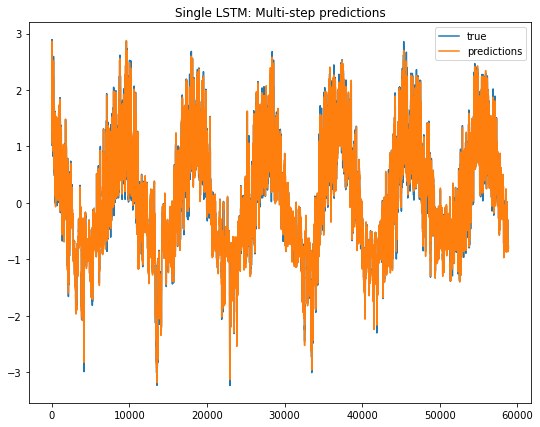

In [69]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single, label = 'predictions')
plt.title("Single LSTM: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

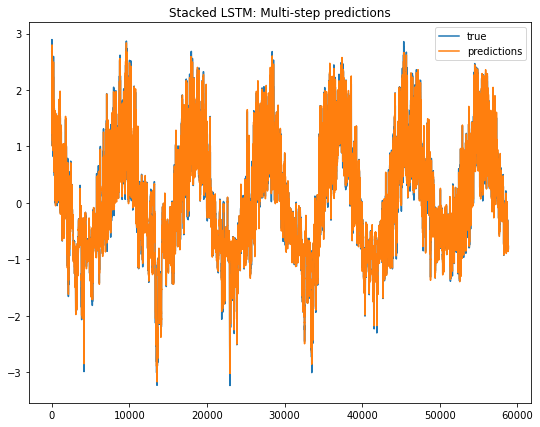

In [70]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_stacked, label = 'predictions')
plt.title("Stacked LSTM: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

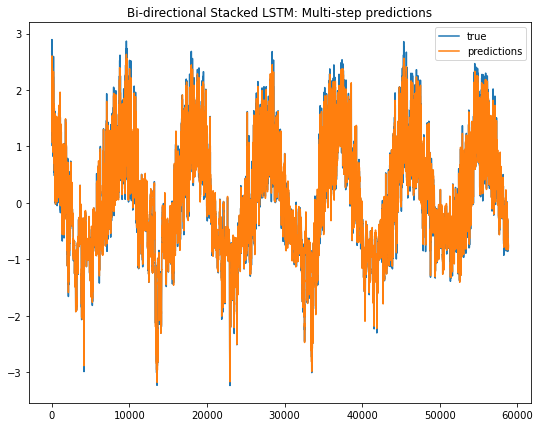

In [71]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_bi_stacked, label = 'predictions')
plt.title("Bi-directional Stacked LSTM: Multi-step predictions")
plt.legend(loc =  'best')
plt.show()

In [72]:
# Compute MAE-
mae_single = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_single)
mae_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mae_bi_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)

In [73]:
# Compute MSE-
mse_single = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_single)
mse_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mse_bi_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)

In [74]:
# Compute RMSE-
rmse_single = np.sqrt(mse_single)
rmse_stacked = np.sqrt(mse_stacked)
rmse_bi_stacked = np.sqrt(mse_bi_stacked)

In [75]:
print("Validation metrics for different LSTM Multi-step models are:")
print(f"MAE single = {mae_single:.4f}, MAE stacked = {mae_stacked:.4f} & MAE bi-directional stacked = {mae_bi_stacked:.4f}")
print(f"MSE single = {mse_single:.4f}, MSE stacked = {mse_stacked:.4f} & MSE bi-directional stacked = {mse_bi_stacked:.4f}")
print(f"RMSE single = {rmse_single:.4f}, RMSE stacked = {rmse_stacked:.4f} & RMSE bi-directional stacked = {rmse_bi_stacked:.4f}")

Validation metrics for different LSTM Multi-step models are:
MAE single = 0.0520, MAE stacked = 0.0585 & MAE bi-directional stacked = 0.0593
MSE single = 0.0053, MSE stacked = 0.0064 & MSE bi-directional stacked = 0.0066
RMSE single = 0.0728, RMSE stacked = 0.0798 & RMSE bi-directional stacked = 0.0811


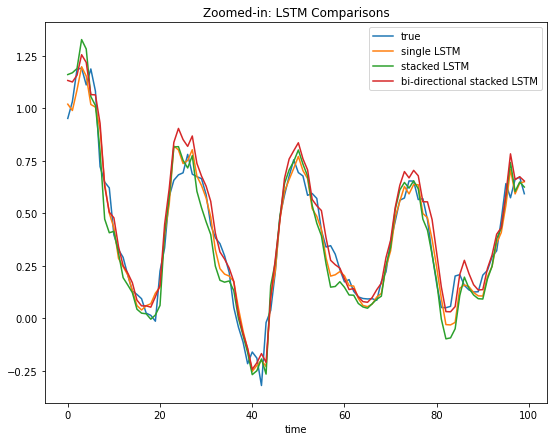

In [92]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[20000:20100], label = 'true')
plt.plot(predictions_single[20000:20100], label = 'single LSTM')
plt.plot(predictions_stacked[20000:20100], label = 'stacked LSTM')
plt.plot(predictions_bi_stacked[20000:20100], label = 'bi-directional stacked LSTM')
plt.title("Zoomed-in: LSTM Comparisons")
plt.legend(loc = 'best')
plt.xlabel("time")
plt.show()

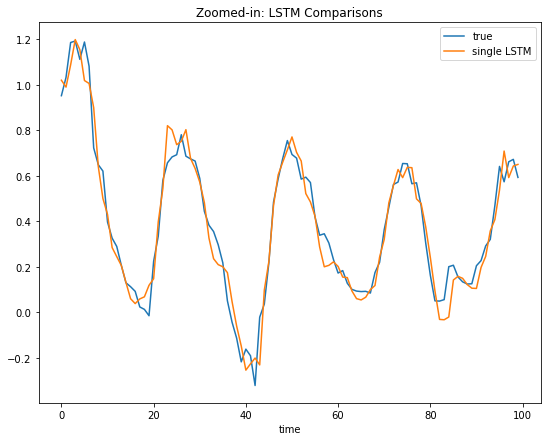

In [93]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single[20000:20100], label = 'true')
plt.plot(predictions_single[20000:20100], label = 'single LSTM')
plt.legend(loc = 'best')
plt.xlabel("time")
plt.title("Zoomed-in: LSTM Comparisons")
plt.show()

In [94]:
# Save trained models-
single_model.save("Single_multistep_LSTM_weather_model.h5", overwrite = True)
stacked_model.save("Stacked_multistep_LSTM_weather_model.h5", overwrite = True)
stacked_bi_model.save("Stacked_multistep_bi_Directional_LSTM_weather_model.h5", overwrite = True)

In [95]:
del single_model, stacked_model, stacked_bi_model